**660710731  ฟาเซีย เหมียนเอียด**

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('cafethai_prices.csv', parse_dates=['date'], date_format='%d/%m/%Y')
display(df.head())

,date,time,cash_type,coffee_name,money
0,2023-03-01,08:04:19,card,Latte,75
1,2023-03-01,08:08:54,cash,Americano with Milk,70
2,2023-03-01,08:09:03,card,Cappuccino,75
3,2023-03-01,08:10:26,cash,Cappuccino,75
4,2023-03-01,08:15:37,cash,Cappuccino,75


In [3]:
df.set_index('date', inplace=True)

df.head()

,time,cash_type,coffee_name,money
date,,,,
2023-03-01,08:04:19,card,Latte,75
2023-03-01,08:08:54,cash,Americano with Milk,70
2023-03-01,08:09:03,card,Cappuccino,75
2023-03-01,08:10:26,cash,Cappuccino,75
2023-03-01,08:15:37,cash,Cappuccino,75


In [4]:
#รวมข้อมูลยอดขายแต่ละเมนู ในแต่ละวัน
daily_sales = df.groupby(['date', 'coffee_name'])['money'].sum().reset_index()
daily_sales.head()

,date,coffee_name,money
0,2023-03-01,Americano,1235
1,2023-03-01,Americano with Milk,1890
2,2023-03-01,Cappuccino,1800
3,2023-03-01,Cocoa,350
4,2023-03-01,Cortado,980


In [5]:
# DataFrame for the count of each coffee item sold per day
daily_item_counts = df.groupby(['date', 'coffee_name']).size().reset_index(name='count')
daily_item_counts.head()

,date,coffee_name,count
0,2023-03-01,Americano,19
1,2023-03-01,Americano with Milk,27
2,2023-03-01,Cappuccino,24
3,2023-03-01,Cocoa,7
4,2023-03-01,Cortado,14


In [6]:
# DataFrame for the total sales per day for all coffee items
daily_total_sales = df.groupby('date')['money'].sum().reset_index(name='total_sales')
daily_total_sales.head()

,date,total_sales
0,2023-03-01,8645
1,2023-03-02,8560
2,2023-03-03,8690
3,2023-03-04,4365
4,2023-03-05,4565


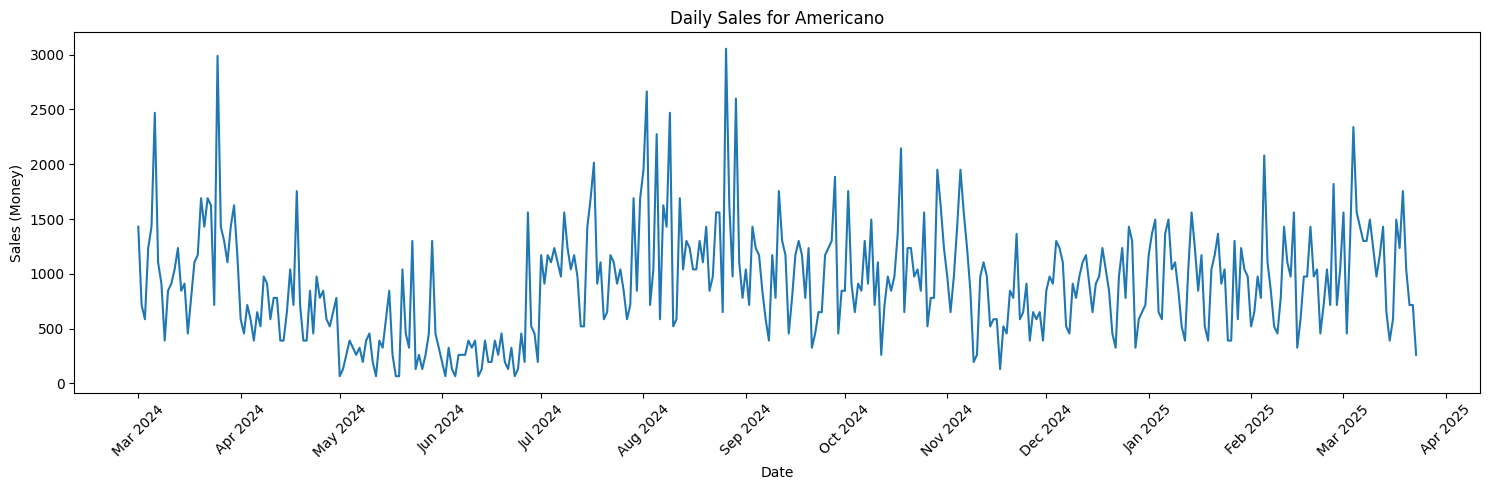

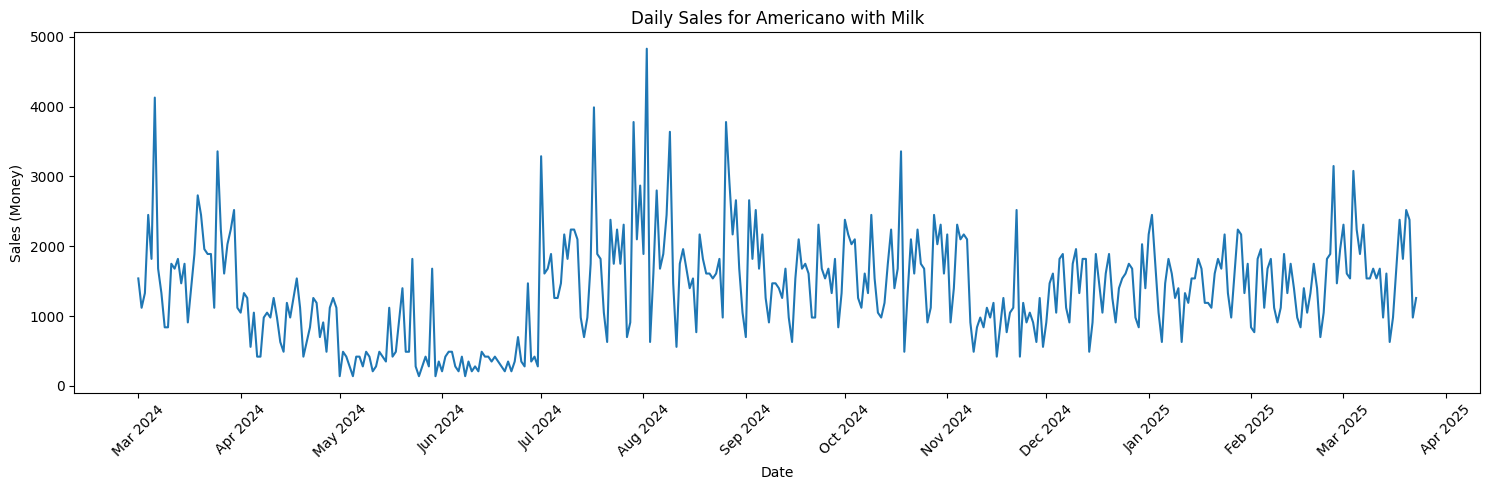

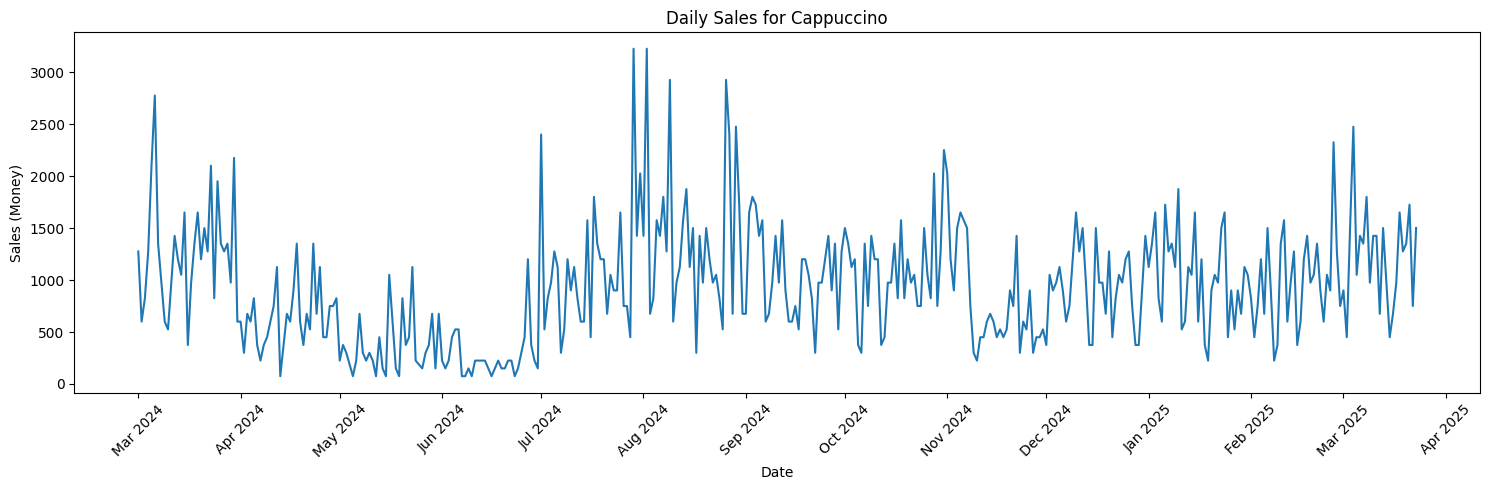

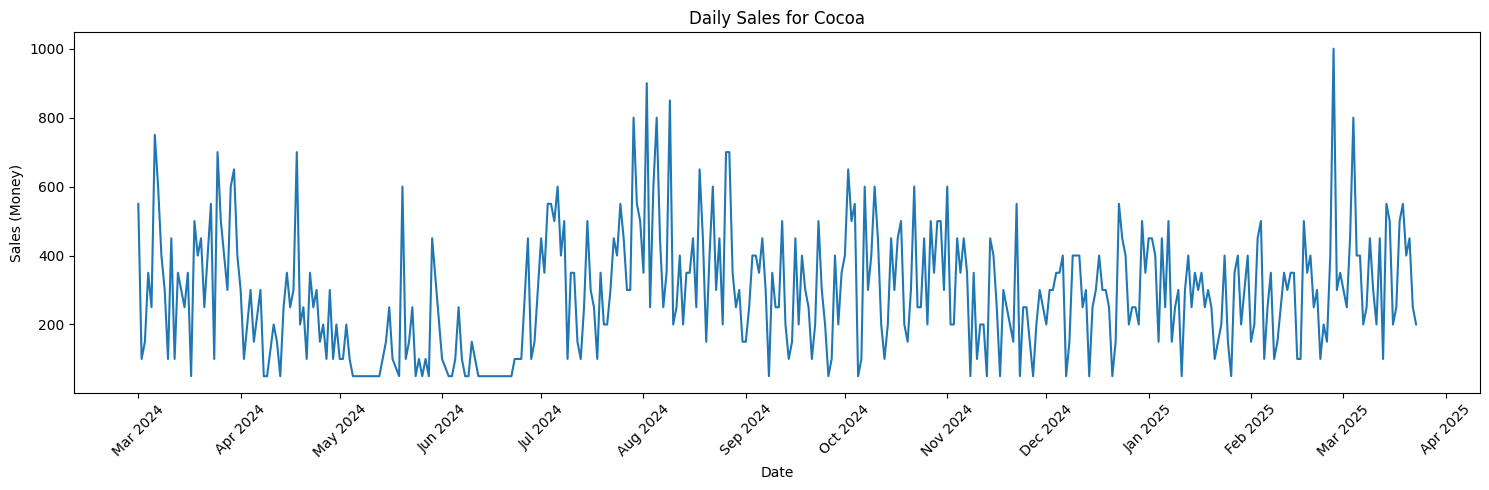

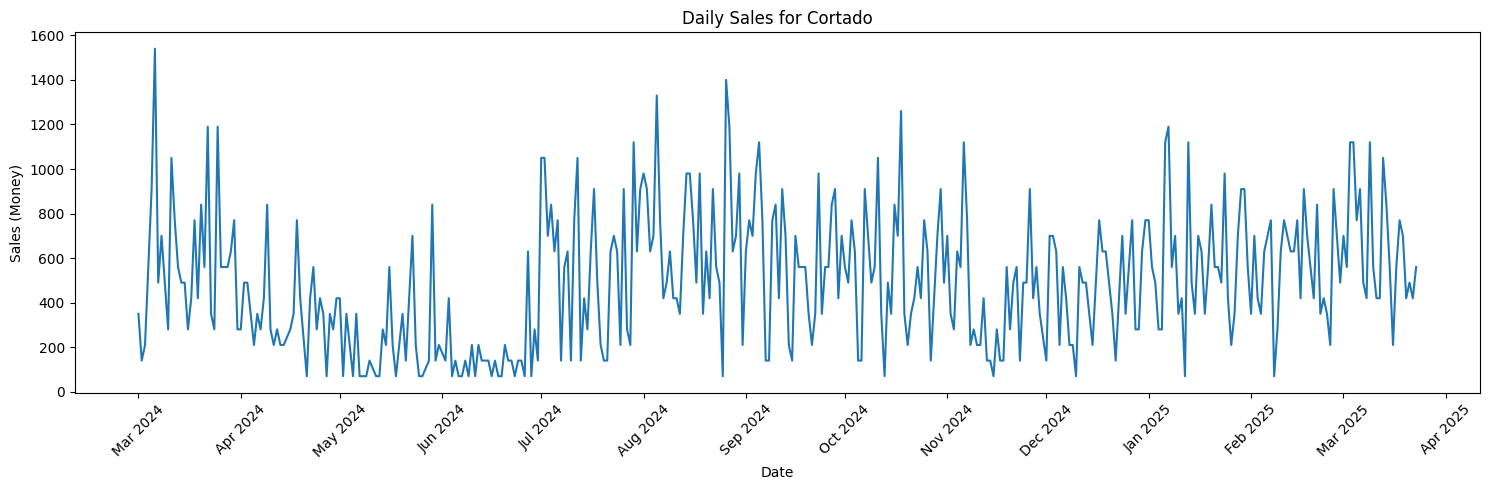

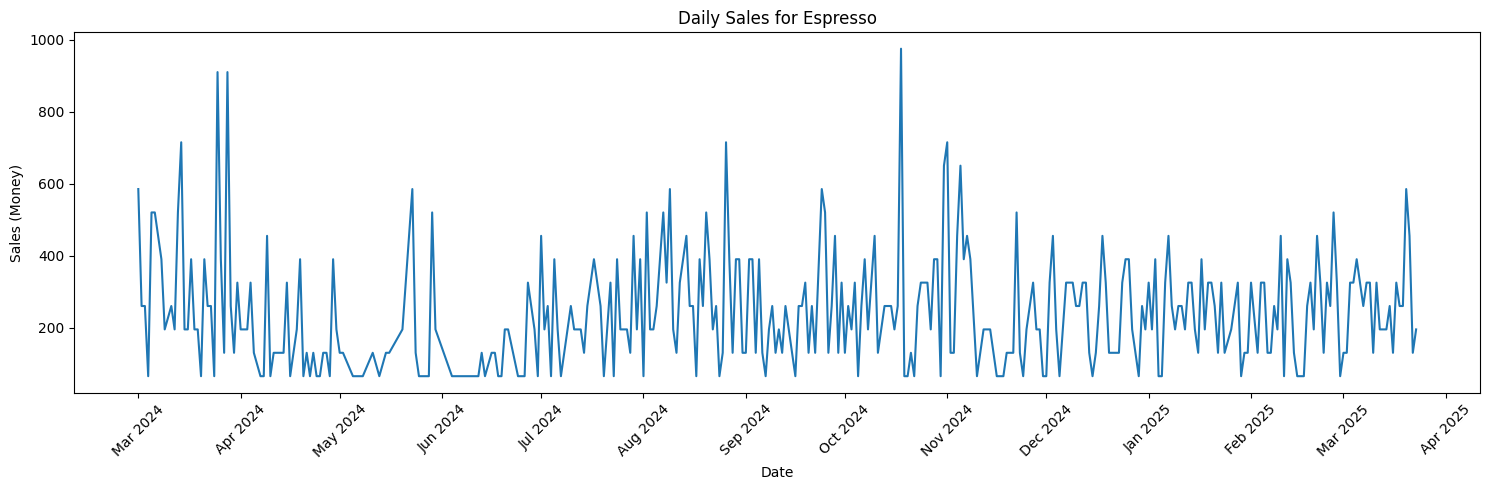

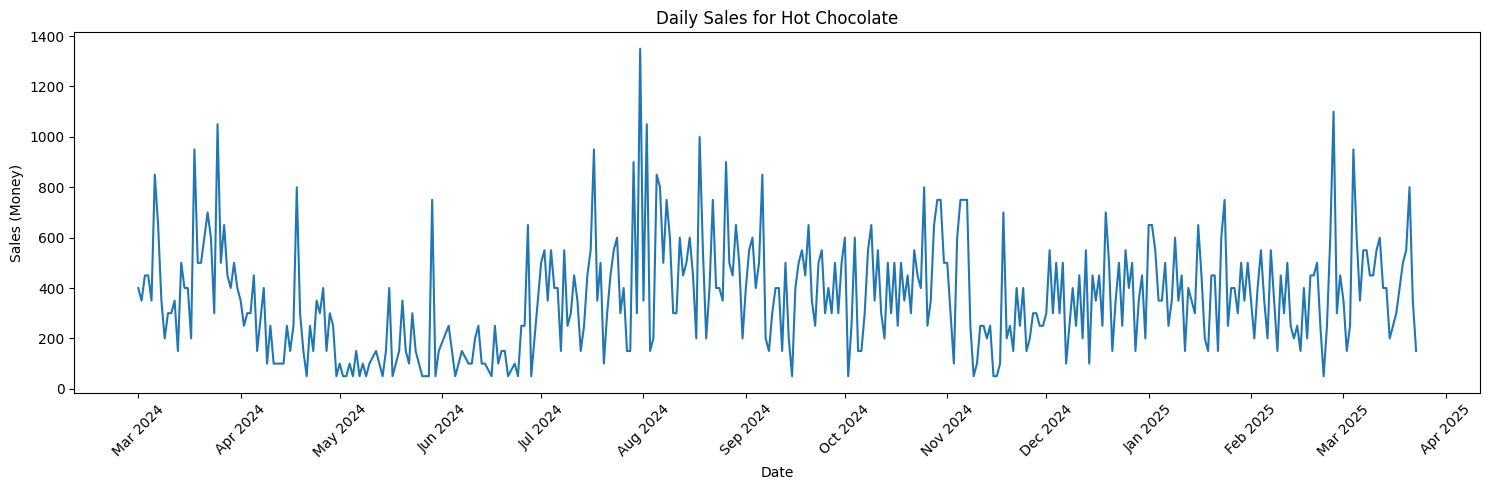

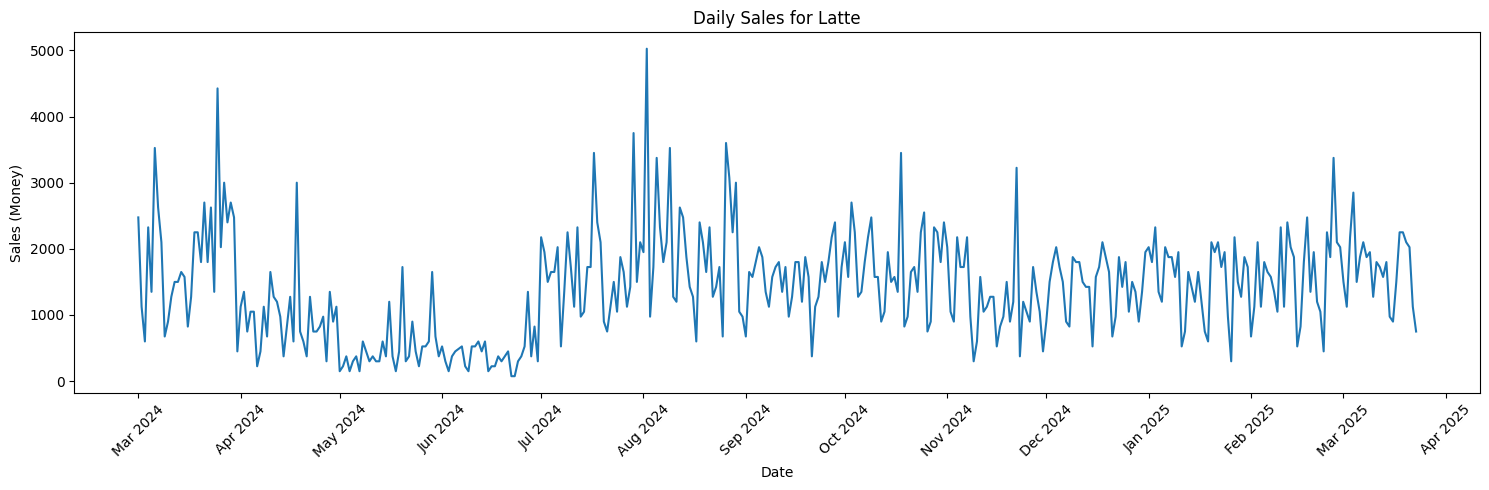

In [7]:
# Plot daily sales for each coffee item
for coffee_name in daily_sales['coffee_name'].unique():
    coffee_sales = daily_sales[daily_sales['coffee_name'] == coffee_name].copy() # Create a copy to avoid SettingWithCopyWarning
    # Ensure date is datetime, convert if needed with the correct format
    if not pd.api.types.is_datetime64_any_dtype(coffee_sales['date']):
         coffee_sales['date'] = pd.to_datetime(coffee_sales['date'], format='%d/%m/%Y', errors='coerce')

    coffee_sales.dropna(subset=['date'], inplace=True) # Remove rows with invalid dates

    # Filter data by date range
    # Update start and end dates if needed based on the correct format
    start_date = '2024-03-01' # Assuming the user wants to start from March 1, 2024
    end_date = '2025-03-23'
    coffee_sales = coffee_sales[(coffee_sales['date'] >= start_date) & (coffee_sales['date'] <= end_date)]

    coffee_sales.set_index('date', inplace=True) # Set date as index for easier plotting


    plt.figure(figsize=(15, 5))
    plt.plot(coffee_sales.index, coffee_sales['money'])
    plt.title(f'Daily Sales for {coffee_name}')
    plt.xlabel('Date')
    plt.ylabel('Sales (Money)')

    # Format x-axis to show month and year
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b %Y'))
    plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())


    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [8]:
def create_sales_features_per_product(df):
    # แปลง date เป็น datetime
    if not pd.api.types.is_datetime64_any_dtype(df['date']):
        df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y', errors='coerce')
    df.dropna(subset=['date'], inplace=True)  # ลบ rows ที่ date ไม่ถูกต้อง

    # เก็บฟีเจอร์ทุกสินค้า
    feature_dfs = []

    # Loop แต่ละสินค้า
    for product in df['coffee_name'].unique():
        product_df = df[df['coffee_name'] == product].copy()
        product_df.sort_values('date', inplace=True)
        product_df.set_index('date', inplace=True)

        # ฟีเจอร์จาก date
        product_df['dayofweek'] = product_df.index.dayofweek
        product_df['quarter'] = product_df.index.quarter
        product_df['month'] = product_df.index.month
        product_df['dayofyear'] = product_df.index.dayofyear
        product_df['year'] = product_df.index.year

        # Lag features
        product_df['lag_7'] = product_df['money'].shift(7)
        product_df['lag_14'] = product_df['money'].shift(14)

        # Rolling mean
        product_df['rolling_mean_7'] = product_df['money'].shift(1).rolling(window=7).mean()

        product_df.reset_index(inplace=True)
        feature_dfs.append(product_df)  # เพิ่มผลลัพธ์เข้า list

    # รวมข้อมูลทุกสินค้า
    df_features = pd.concat(feature_dfs, ignore_index=True)
    df_features.dropna(inplace=True)
    return df_features

    # สร้างฟีเจอร์แยกสินค้า
daily_sales_features_per_product = create_sales_features_per_product(daily_sales.copy())

# ดูตัวอย่างข้อมูลรวมทั้งหมด
display(daily_sales_features_per_product.head())

# แยก print แสดงข้อมูลแต่ละสินค้า
for product, group in daily_sales_features_per_product.groupby('coffee_name'):
    print(f"\n=== ตัวอย่างข้อมูลสินค้า: {product} ===")
    display(group.head())



,date,coffee_name,money,dayofweek,quarter,month,dayofyear,year,lag_7,lag_14,rolling_mean_7
14,2023-03-15,Americano,1430,2,1,3,74,2023,1365.0,1235.0,1058.571429
15,2023-03-16,Americano,1495,3,1,3,75,2023,1105.0,1235.0,1067.857143
16,2023-03-17,Americano,780,4,1,3,76,2023,1105.0,1235.0,1123.571429
17,2023-03-18,Americano,845,5,1,3,77,2023,585.0,715.0,1077.142857
18,2023-03-19,Americano,910,6,1,3,78,2023,585.0,715.0,1114.285714



=== ตัวอย่างข้อมูลสินค้า: Americano ===


,date,coffee_name,money,dayofweek,quarter,month,dayofyear,year,lag_7,lag_14,rolling_mean_7
14,2023-03-15,Americano,1430,2,1,3,74,2023,1365.0,1235.0,1058.571429
15,2023-03-16,Americano,1495,3,1,3,75,2023,1105.0,1235.0,1067.857143
16,2023-03-17,Americano,780,4,1,3,76,2023,1105.0,1235.0,1123.571429
17,2023-03-18,Americano,845,5,1,3,77,2023,585.0,715.0,1077.142857
18,2023-03-19,Americano,910,6,1,3,78,2023,585.0,715.0,1114.285714



=== ตัวอย่างข้อมูลสินค้า: Americano with Milk ===


,date,coffee_name,money,dayofweek,quarter,month,dayofyear,year,lag_7,lag_14,rolling_mean_7
804,2023-03-15,Americano with Milk,1540,2,1,3,74,2023,2030.0,1890.0,1540.0
805,2023-03-16,Americano with Milk,1260,3,1,3,75,2023,1680.0,1820.0,1470.0
806,2023-03-17,Americano with Milk,1960,4,1,3,76,2023,1330.0,1890.0,1410.0
807,2023-03-18,Americano with Milk,980,5,1,3,77,2023,1680.0,630.0,1500.0
808,2023-03-19,Americano with Milk,1120,6,1,3,78,2023,980.0,1120.0,1400.0



=== ตัวอย่างข้อมูลสินค้า: Cappuccino ===


,date,coffee_name,money,dayofweek,quarter,month,dayofyear,year,lag_7,lag_14,rolling_mean_7
1595,2023-03-15,Cappuccino,1200,2,1,3,74,2023,825.0,1800.0,996.428571
1596,2023-03-16,Cappuccino,1575,3,1,3,75,2023,1125.0,1350.0,1050.000000
1597,2023-03-17,Cappuccino,1800,4,1,3,76,2023,1050.0,1200.0,1114.285714
1598,2023-03-18,Cappuccino,900,5,1,3,77,2023,975.0,900.0,1221.428571
1599,2023-03-19,Cappuccino,825,6,1,3,78,2023,600.0,750.0,1210.714286



=== ตัวอย่างข้อมูลสินค้า: Cocoa ===


,date,coffee_name,money,dayofweek,quarter,month,dayofyear,year,lag_7,lag_14,rolling_mean_7
2379,2023-03-15,Cocoa,150,2,1,3,74,2023,300.0,350.0,207.142857
2380,2023-03-16,Cocoa,300,3,1,3,75,2023,300.0,400.0,185.714286
2381,2023-03-17,Cocoa,250,4,1,3,76,2023,200.0,350.0,185.714286
2382,2023-03-18,Cocoa,250,5,1,3,77,2023,100.0,200.0,192.857143
2383,2023-03-19,Cocoa,250,6,1,3,78,2023,150.0,100.0,214.285714



=== ตัวอย่างข้อมูลสินค้า: Cortado ===


,date,coffee_name,money,dayofweek,quarter,month,dayofyear,year,lag_7,lag_14,rolling_mean_7
3140,2023-03-15,Cortado,490,2,1,3,74,2023,700.0,980.0,540.0
3141,2023-03-16,Cortado,420,3,1,3,75,2023,490.0,560.0,510.0
3142,2023-03-17,Cortado,350,4,1,3,76,2023,700.0,350.0,500.0
3143,2023-03-18,Cortado,350,5,1,3,77,2023,490.0,280.0,450.0
3144,2023-03-19,Cortado,280,6,1,3,78,2023,280.0,560.0,430.0



=== ตัวอย่างข้อมูลสินค้า: Espresso ===


,date,coffee_name,money,dayofweek,quarter,month,dayofyear,year,lag_7,lag_14,rolling_mean_7
3913,2023-03-16,Espresso,390,3,1,3,75,2023,390.0,390.0,213.571429
3914,2023-03-17,Espresso,195,4,1,3,76,2023,260.0,520.0,213.571429
3915,2023-03-18,Espresso,325,5,1,3,77,2023,130.0,390.0,204.285714
3916,2023-03-19,Espresso,130,6,1,3,78,2023,65.0,65.0,232.142857
3917,2023-03-20,Espresso,325,0,1,3,79,2023,325.0,195.0,241.428571



=== ตัวอย่างข้อมูลสินค้า: Hot Chocolate ===


,date,coffee_name,money,dayofweek,quarter,month,dayofyear,year,lag_7,lag_14,rolling_mean_7
4623,2023-03-15,Hot Chocolate,600,2,1,3,74,2023,150.0,200.0,257.142857
4624,2023-03-16,Hot Chocolate,150,3,1,3,75,2023,400.0,350.0,321.428571
4625,2023-03-17,Hot Chocolate,300,4,1,3,76,2023,300.0,500.0,285.714286
4626,2023-03-18,Hot Chocolate,250,5,1,3,77,2023,50.0,300.0,285.714286
4627,2023-03-19,Hot Chocolate,200,6,1,3,78,2023,150.0,150.0,314.285714



=== ตัวอย่างข้อมูลสินค้า: Latte ===


,date,coffee_name,money,dayofweek,quarter,month,dayofyear,year,lag_7,lag_14,rolling_mean_7
5394,2023-03-15,Latte,1725,2,1,3,74,2023,1725.0,1800.0,1628.571429
5395,2023-03-16,Latte,1725,3,1,3,75,2023,1650.0,2325.0,1628.571429
5396,2023-03-17,Latte,1875,4,1,3,76,2023,2175.0,2775.0,1639.285714
5397,2023-03-18,Latte,1350,5,1,3,77,2023,1725.0,1275.0,1596.428571
5398,2023-03-19,Latte,1050,6,1,3,78,2023,825.0,975.0,1542.857143


In [9]:
# Convert 'date' column to datetime objects
# Ensure 'date' is a column first if it was set as index
if df.index.name == 'date':
    df.reset_index(inplace=True)

df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y', errors='coerce')

# Display the data types to confirm the conversion
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68359 entries, 0 to 68358
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         68359 non-null  datetime64[ns]
 1   time         68359 non-null  object        
 2   cash_type    68359 non-null  object        
 3   coffee_name  68359 non-null  object        
 4   money        68359 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 2.6+ MB


None

In [10]:
FEATURES = ['dayofweek', 'quarter', 'month', 'dayofyear', 'lag_7', 'lag_14', 'rolling_mean_7']
TARGET = 'money'

In [11]:
X = daily_sales_features_per_product[FEATURES]
y = daily_sales_features_per_product[TARGET]

In [12]:
# กำหนดวันที่ split
split_date = pd.to_datetime('2025-03-01')

# แปลง date เป็น datetime
daily_sales_features_per_product['date'] = pd.to_datetime(daily_sales_features_per_product['date'])

# Dictionary เก็บ train/test per product
split_data = {}

for product, group in daily_sales_features_per_product.groupby('coffee_name'):
    train_data = group[group['date'] < split_date]
    test_data = group[group['date'] >= split_date]

    X_train = train_data[FEATURES]
    y_train = train_data[TARGET]
    X_test = test_data[FEATURES]
    y_test = test_data[TARGET]

    split_data[product] = {
        'X_train': X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test
    }

    print(f"\n=== {product} ===")
    print(f"Shape of X_train: {X_train.shape}")
    print(f"Shape of y_train: {y_train.shape}")
    print(f"Shape of X_test: {X_test.shape}")
    print(f"Shape of y_test: {y_test.shape}")



=== Americano ===
Shape of X_train: (715, 7)
Shape of y_train: (715,)
Shape of X_test: (61, 7)
Shape of y_test: (61,)

=== Americano with Milk ===
Shape of X_train: (716, 7)
Shape of y_train: (716,)
Shape of X_test: (61, 7)
Shape of y_test: (61,)

=== Cappuccino ===
Shape of X_train: (709, 7)
Shape of y_train: (709,)
Shape of X_test: (61, 7)
Shape of y_test: (61,)

=== Cocoa ===
Shape of X_train: (687, 7)
Shape of y_train: (687,)
Shape of X_test: (60, 7)
Shape of y_test: (60,)

=== Cortado ===
Shape of X_train: (698, 7)
Shape of y_train: (698,)
Shape of X_test: (61, 7)
Shape of y_test: (61,)

=== Espresso ===
Shape of X_train: (640, 7)
Shape of y_train: (640,)
Shape of X_test: (56, 7)
Shape of y_test: (56,)

=== Hot Chocolate ===
Shape of X_train: (696, 7)
Shape of y_train: (696,)
Shape of X_test: (61, 7)
Shape of y_test: (61,)

=== Latte ===
Shape of X_train: (716, 7)
Shape of y_train: (716,)
Shape of X_test: (61, 7)
Shape of y_test: (61,)


In [13]:
# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [14]:
# XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=100,
                             learning_rate=0.05, # ค่อยๆ เรียนรู้ช้าๆ
                             early_stopping_rounds=10, # ถ้าผลไม่ดีขึ้น 10 รอบให้หยุด
                             random_state=42)

In [15]:
# XGBoost ต้องมี evaluation set เพื่อใช้ early stopping
xgb_model.fit(X_train, y_train,
              eval_set=[(X_test, y_test)],
              verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [16]:
rf_pred = rf_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)

In [17]:
rf_mae = mean_absolute_error(y_test, rf_pred)
xgb_mae = mean_absolute_error(y_test, xgb_pred)

In [18]:
print(f"\nความคลาดเคลื่อนเฉลี่ยของ Random Forest: {rf_mae:.2f} จากทั้งหมด {len(y_test)} จุดข้อมูล")
print(f"ความคลาดเคลื่อนเฉลี่ยของ XGBoost: {xgb_mae:.2f} จากทั้งหมด {len(y_test)} จุดข้อมูล")
print(f"ยอดขายรวมใน Test Set: {y_test.sum():.2f} บาท")


ความคลาดเคลื่อนเฉลี่ยของ Random Forest: 369.20 จากทั้งหมด 61 จุดข้อมูล
ความคลาดเคลื่อนเฉลี่ยของ XGBoost: 374.79 จากทั้งหมด 61 จุดข้อมูล
ยอดขายรวมใน Test Set: 85650.00 บาท


In [19]:
results = pd.DataFrame({
    'Actual': y_test,
    'Random Forest': rf_pred,
    'XGBoost': xgb_pred
})

# Set the index of the results DataFrame to the dates from the test set
results.index = test_data['date']

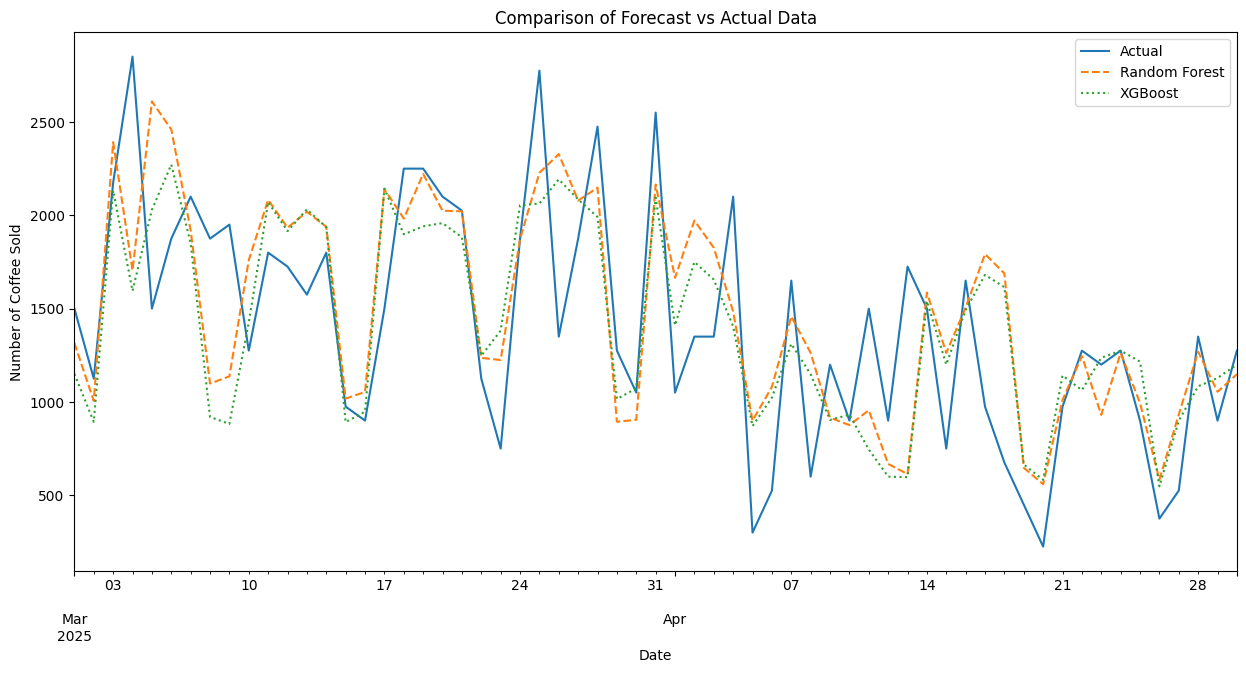

In [20]:
results.plot(figsize=(15, 7), style=['-', '--', ':'],
             title='Comparison of Forecast vs Actual Data')
plt.ylabel('Number of Coffee Sold')
plt.xlabel('Date')
plt.legend()
plt.show()

In [21]:
def plot_feature_importance(model, features, model_name):
    # สร้าง DataFrame ของ feature importance
    fi = pd.DataFrame(data=model.feature_importances_,
                      index=features,
                      columns=['importance'])
    fi_sorted = fi.sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=fi_sorted.index, y=fi_sorted['importance'])
    plt.title(f'Feature Importance of the {model_name} Model') # Changed title to English
    plt.xticks(rotation=45)
    plt.xlabel('Features') # Added x-axis label
    plt.show()

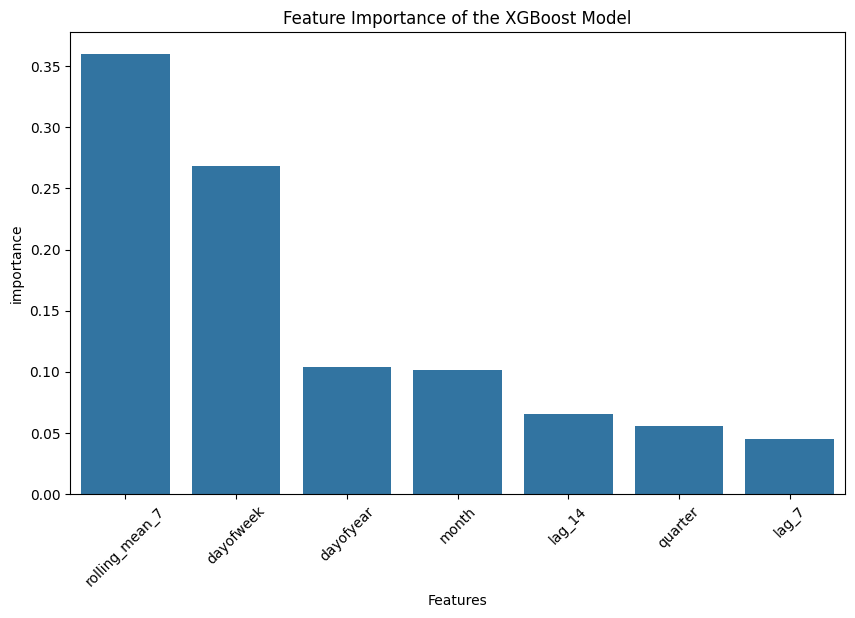

In [22]:
plot_feature_importance(xgb_model, FEATURES, 'XGBoost')

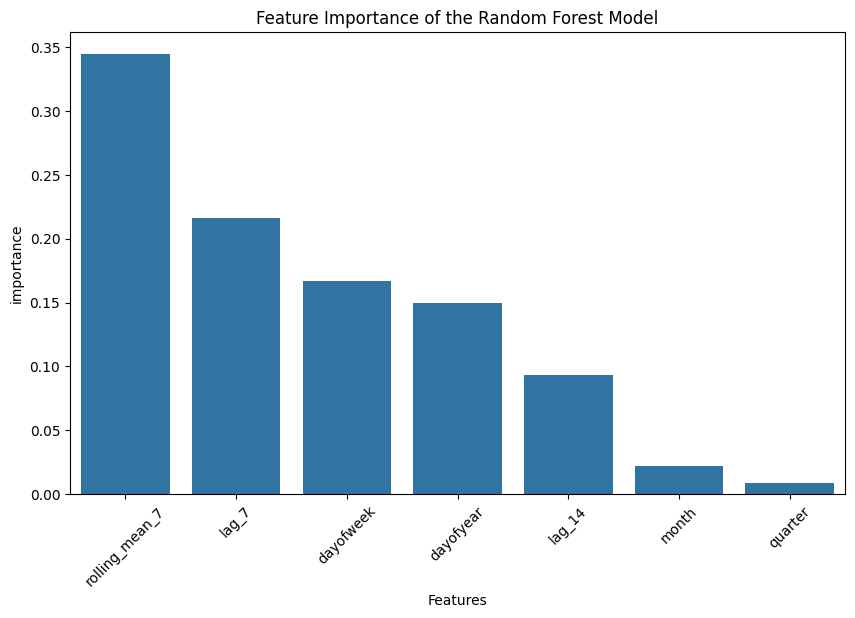

In [23]:
plot_feature_importance(rf_model, FEATURES, 'Random Forest')

In [24]:
!pip install prophet

In [25]:
from prophet import Prophet

In [26]:
# Prepare data for Prophet: requires 'ds' (datetime) and 'y' (target) columns
# Use the already split train_data and test_data DataFrames

# Add print statements to check columns
print("Columns in train_data:", train_data.columns)
print("Columns in test_data:", test_data.columns)

Columns in train_data: Index(['date', 'coffee_name', 'money', 'dayofweek', 'quarter', 'month',
       'dayofyear', 'year', 'lag_7', 'lag_14', 'rolling_mean_7'],
      dtype='object')
Columns in test_data: Index(['date', 'coffee_name', 'money', 'dayofweek', 'quarter', 'month',
       'dayofyear', 'year', 'lag_7', 'lag_14', 'rolling_mean_7'],
      dtype='object')


In [27]:
# Display the index (dates) of the RF/XGBoost test set
display(y_test.index)

Index([6110, 6111, 6112, 6113, 6114, 6115, 6116, 6117, 6118, 6119, 6120, 6121,
       6122, 6123, 6124, 6125, 6126, 6127, 6128, 6129, 6130, 6131, 6132, 6133,
       6134, 6135, 6136, 6137, 6138, 6139, 6140, 6141, 6142, 6143, 6144, 6145,
       6146, 6147, 6148, 6149, 6150, 6151, 6152, 6153, 6154, 6155, 6156, 6157,
       6158, 6159, 6160, 6161, 6162, 6163, 6164, 6165, 6166, 6167, 6168, 6169,
       6170],
      dtype='int64')

In [28]:
plit_date = pd.to_datetime('2025-03-01')

# Loop ผ่านแต่ละสินค้า
for product, group in daily_sales_features_per_product.groupby('coffee_name'):
    # แยก train/test
    test_data = group[group['date'] >= split_date]

    # เตรียมสำหรับ Prophet
    prophet_test = test_data[['date', 'money']].rename(columns={'date': 'ds', 'money': 'y'})

    # สร้างโมเดลและ train ด้วย train_data ของสินค้าเดียว (สมมติ train_data มีอยู่)
    prophet_train = group[group['date'] < split_date][['date', 'money']].rename(columns={'date': 'ds', 'money': 'y'})
    model = Prophet(weekly_seasonality=True, yearly_seasonality=True)
    model.fit(prophet_train)

    # forecast
    forecast = model.predict(prophet_test[['ds']])
    prophet_results = forecast.set_index('ds')[['yhat']].join(prophet_test.set_index('ds')[['y']])
    prophet_results.dropna(inplace=True)

    # คำนวณ MAE และยอดขายรวมของสินค้า
    prophet_mae = mean_absolute_error(prophet_results['y'], prophet_results['yhat'])
    total_sales = prophet_results['y'].sum()

    print(f"\n=== สินค้า: {product} ===")
    print(f"MAE: {prophet_mae:.2f}")
    print(f"ยอดขายใน Test Set: {total_sales:.2f} บาท")


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb1wpihu0/5jrgf8ba.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb1wpihu0/w9gt5ko8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57901', 'data', 'file=/tmp/tmpb1wpihu0/5jrgf8ba.json', 'init=/tmp/tmpb1wpihu0/w9gt5ko8.json', 'output', 'file=/tmp/tmpb1wpihu0/prophet_model3vff4oxl/prophet_model-20250921165328.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:53:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:53:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb1


=== สินค้า: Americano ===
MAE: 296.38
ยอดขายใน Test Set: 55445.00 บาท

=== สินค้า: Americano with Milk ===
MAE: 411.07
ยอดขายใน Test Set: 86940.00 บาท


DEBUG:cmdstanpy:input tempfile: /tmp/tmpb1wpihu0/h3hmmj0t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47417', 'data', 'file=/tmp/tmpb1wpihu0/_805_08p.json', 'init=/tmp/tmpb1wpihu0/h3hmmj0t.json', 'output', 'file=/tmp/tmpb1wpihu0/prophet_modelehmdymp1/prophet_model-20250921165328.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:53:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:53:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb1wpihu0/sjsrvgv8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb1wpihu0/8zhbnnfy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:


=== สินค้า: Cappuccino ===
MAE: 234.90
ยอดขายใน Test Set: 56250.00 บาท

=== สินค้า: Cocoa ===
MAE: 107.03
ยอดขายใน Test Set: 19300.00 บาท


16:53:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:53:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb1wpihu0/7ydm4p4j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb1wpihu0/ioukbxs7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20118', 'data', 'file=/tmp/tmpb1wpihu0/7ydm4p4j.json', 'init=/tmp/tmpb1wpihu0/ioukbxs7.json', 'output', 'file=/tmp/tmpb1wpihu0/prophet_modeljhq9r040/prophet_model-20250921165329.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:53:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:53:29 - cmdstanpy - INFO - Chain [1] don


=== สินค้า: Cortado ===
MAE: 181.42
ยอดขายใน Test Set: 28840.00 บาท

=== สินค้า: Espresso ===
MAE: 95.63
ยอดขายใน Test Set: 12155.00 บาท


DEBUG:cmdstanpy:input tempfile: /tmp/tmpb1wpihu0/v6jgoj63.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89318', 'data', 'file=/tmp/tmpb1wpihu0/gmn8ckc5.json', 'init=/tmp/tmpb1wpihu0/v6jgoj63.json', 'output', 'file=/tmp/tmpb1wpihu0/prophet_modelw_vni10l/prophet_model-20250921165329.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:53:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:53:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb1wpihu0/q38kzhz_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb1wpihu0/v289ya19.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:


=== สินค้า: Hot Chocolate ===
MAE: 133.92
ยอดขายใน Test Set: 21750.00 บาท

=== สินค้า: Latte ===
MAE: 369.79
ยอดขายใน Test Set: 85650.00 บาท


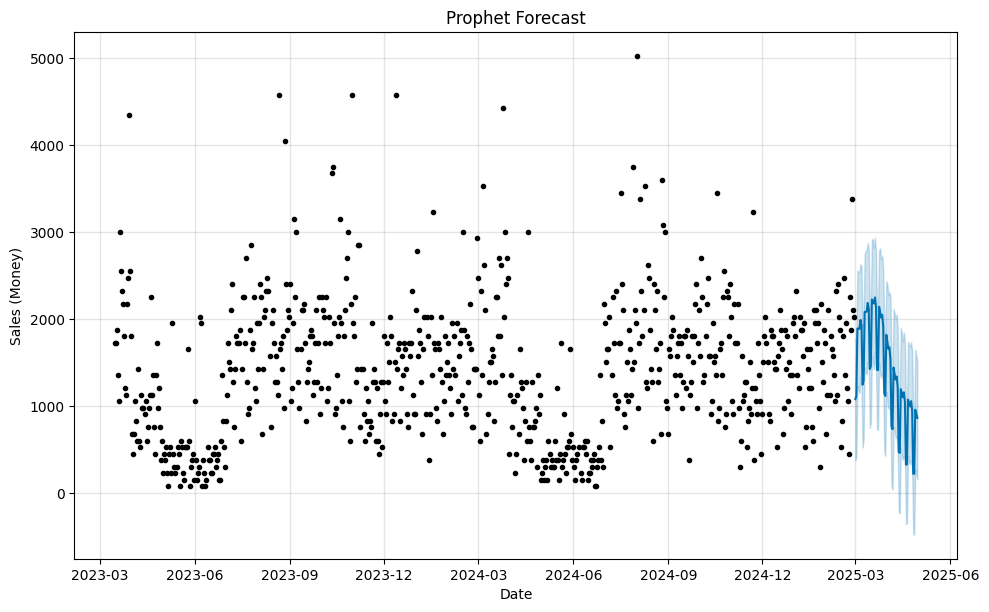

In [29]:
# Plot the forecast
fig1 = model.plot(forecast)
plt.title('Prophet Forecast')
plt.xlabel('Date')
plt.ylabel('Sales (Money)')
plt.show()

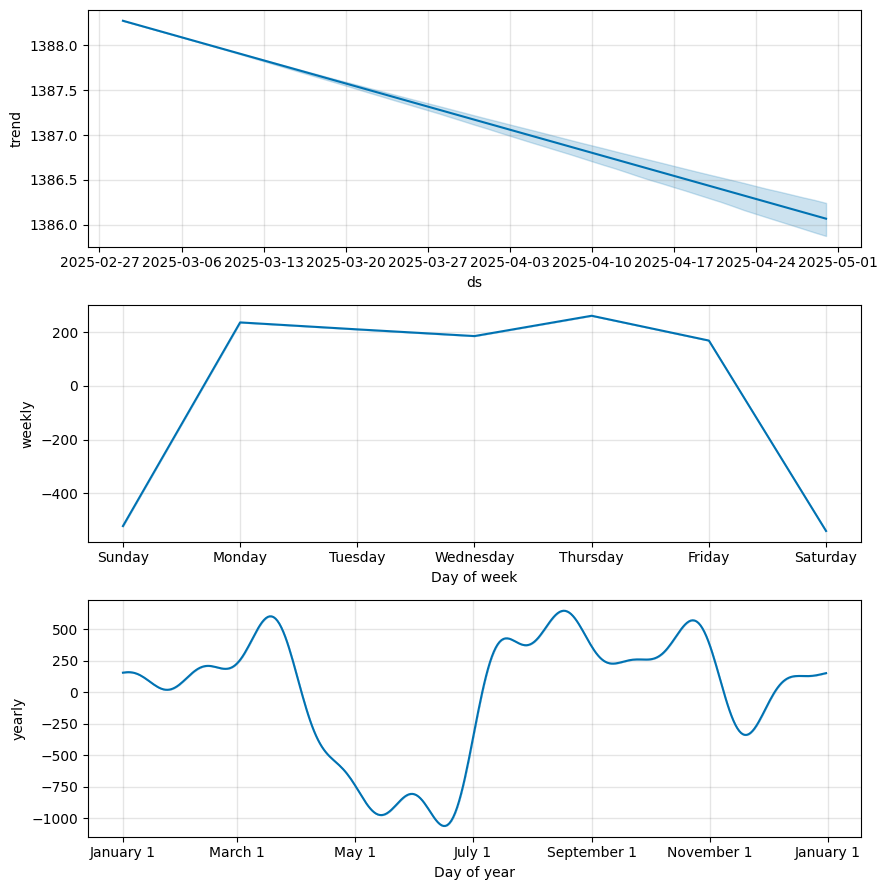

In [30]:
# Plot the components of the forecast
fig2 = model.plot_components(forecast)
plt.show()

In [31]:
pip install git+https://github.com/amazon-science/chronos-forecasting.git

  Cloning https://github.com/amazon-science/chronos-forecasting.git to /tmp/pip-req-build-xtgiu98c
  Running command git clone --filter=blob:none --quiet https://github.com/amazon-science/chronos-forecasting.git /tmp/pip-req-build-xtgiu98c
  Resolved https://github.com/amazon-science/chronos-forecasting.git to commit fcd09fe8b6bf57643bde7847bf42a6719b7ee205
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from chronos import ChronosPipeline

In [33]:
pipeline = ChronosPipeline.from_pretrained(
  "amazon/chronos-t5-small",
  device_map="cuda",
  dtype=torch.bfloat16,
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [34]:
prediction_length = 60
# เก็บผลลัพธ์ทั้งหมด
all_forecasts = []

# Loop ผ่านแต่ละสินค้า
for product, group in daily_sales_features_per_product.groupby('coffee_name'):
    # ข้อมูลก่อน split date
    historical = group[group['date'] < split_date].copy()
    context = torch.tensor(historical['money'].values)

    # Forecast ด้วย pipeline ของ Chronos
    forecast = pipeline.predict(context, prediction_length)

    # เอา median prediction
    median_pred = forecast[0].median(dim=0).values

    # สร้าง DataFrame ของ forecast
    future_dates = pd.date_range(start=split_date, periods=prediction_length, freq='D')
    df_forecast = pd.DataFrame({
        'date': future_dates,
        'coffee_name': product,
        'forecast_median': median_pred
    })

    all_forecasts.append(df_forecast)

# รวมทุกสินค้าเป็น DataFrame เดียว
forecast_df = pd.concat(all_forecasts, ignore_index=True)

# แสดง forecast ของทุกสินค้า
display(forecast_df)

,date,coffee_name,forecast_median
0,2025-03-01,Americano,648.494995
1,2025-03-02,Americano,521.470215
2,2025-03-03,Americano,909.230103
3,2025-03-04,Americano,1103.110107
4,2025-03-05,Americano,1042.940430
...,...,...,...
475,2025-04-25,Latte,823.761963
476,2025-04-26,Latte,454.125214
477,2025-04-27,Latte,528.052551
478,2025-04-28,Latte,749.834656


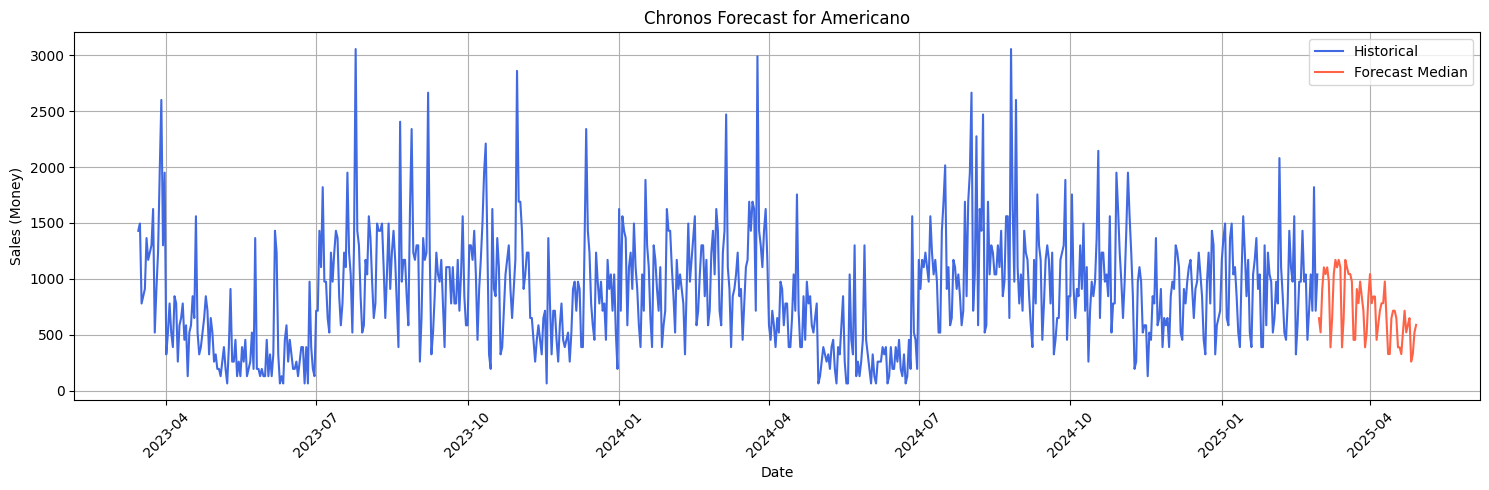

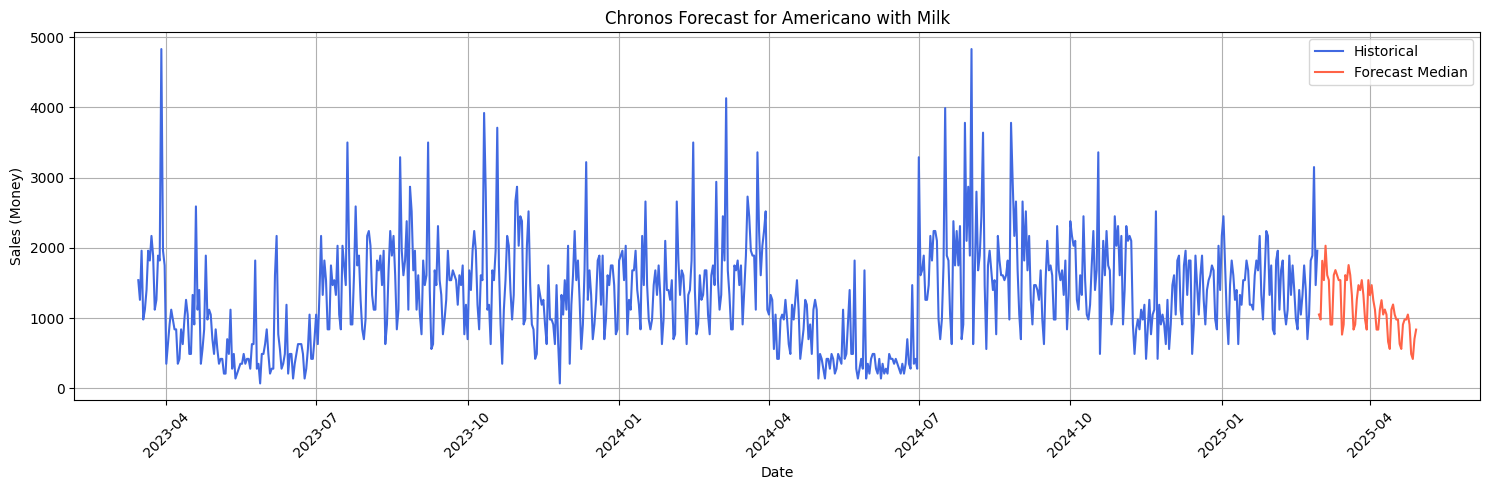

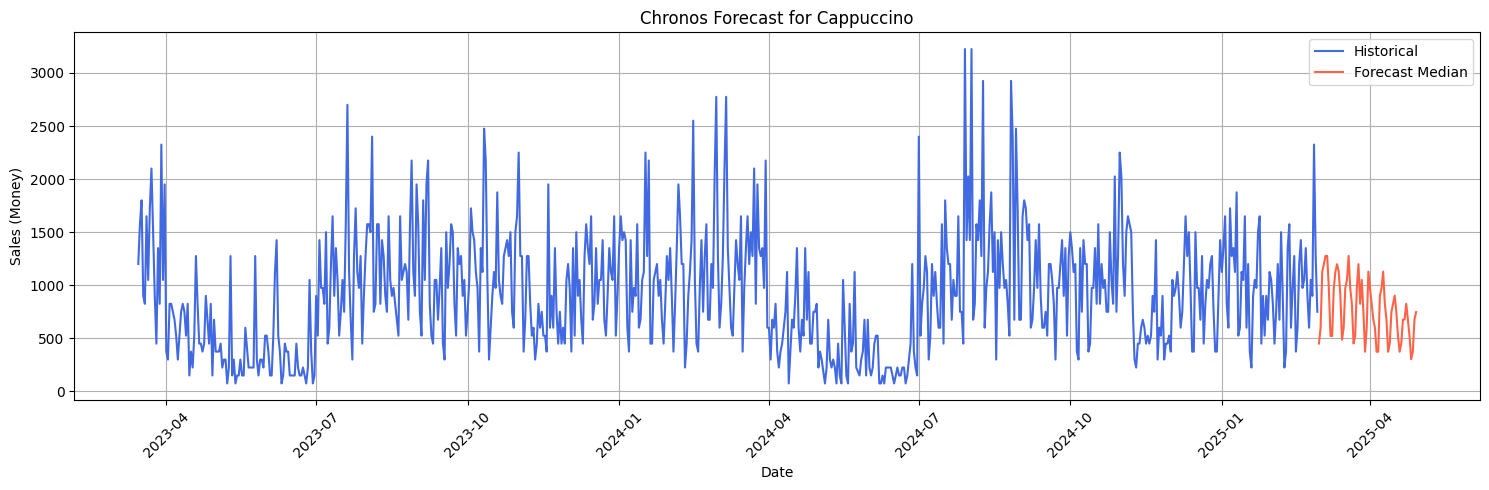

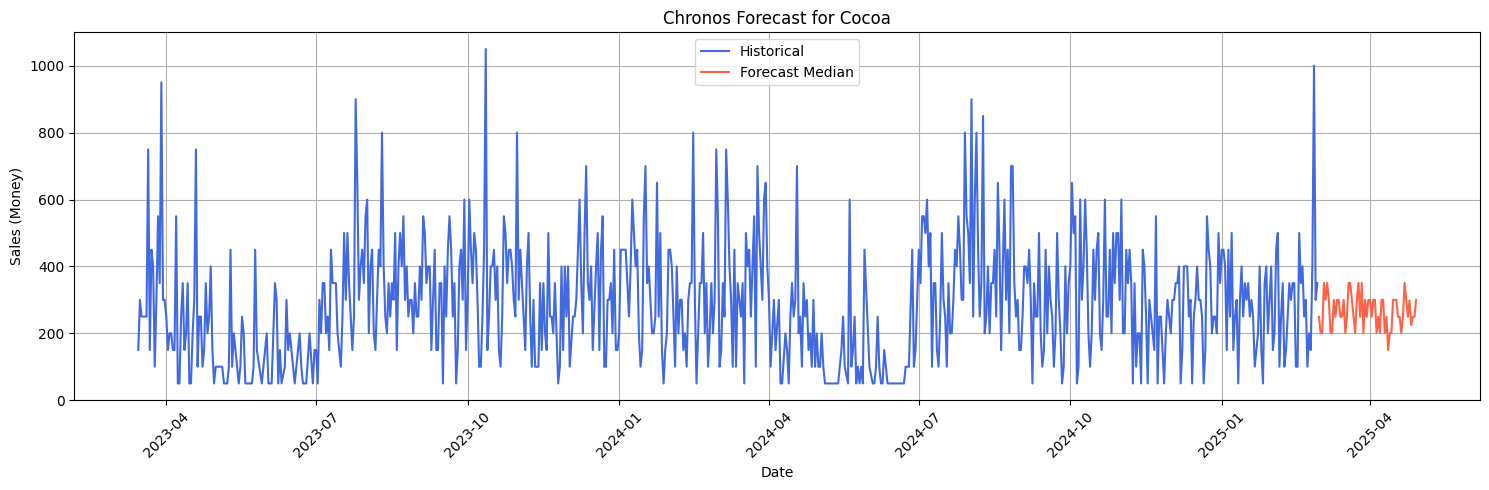

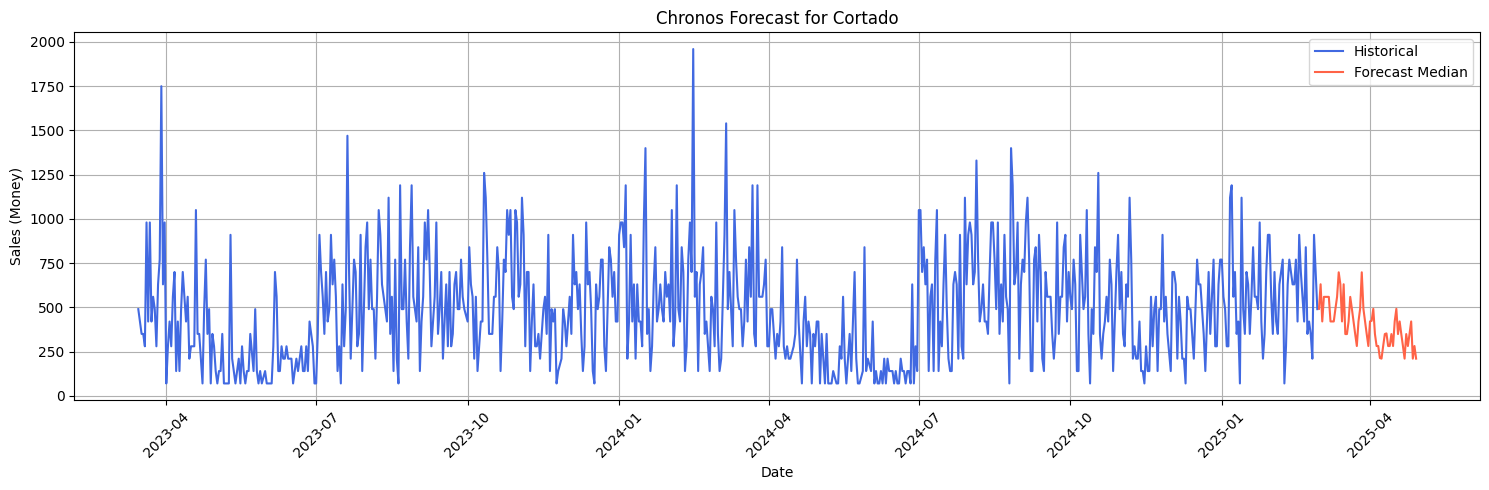

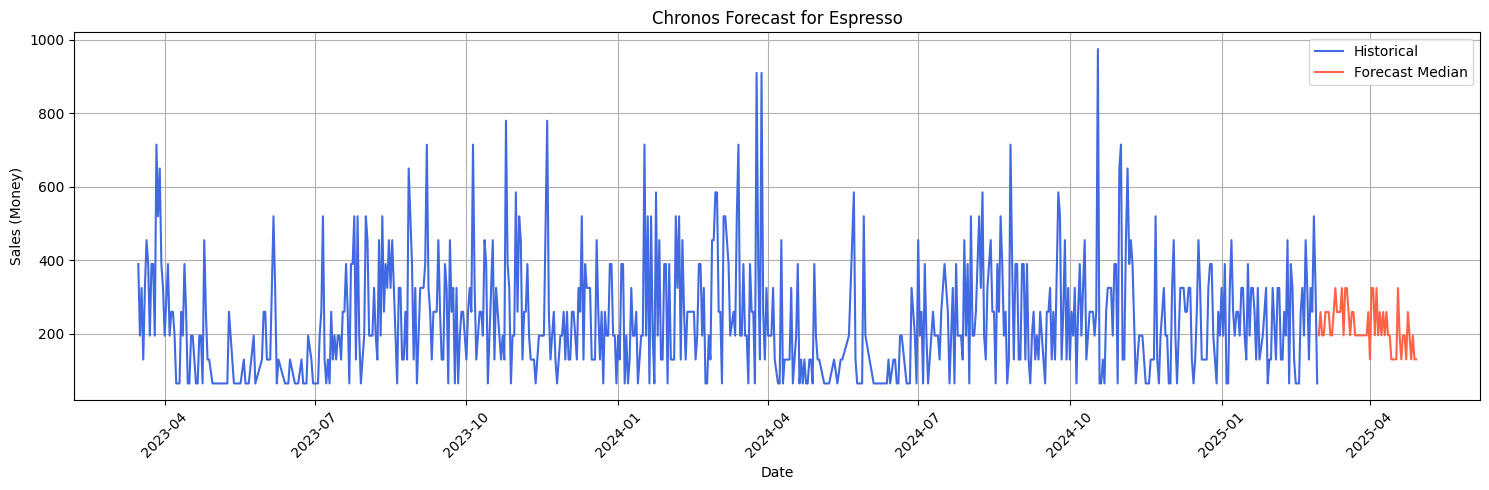

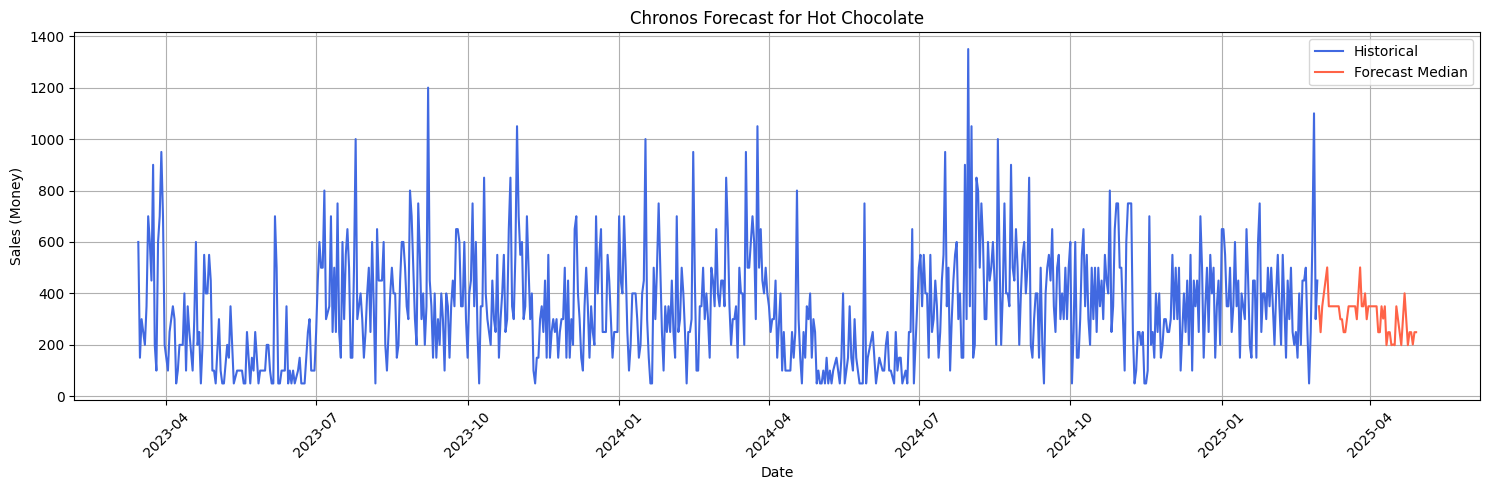

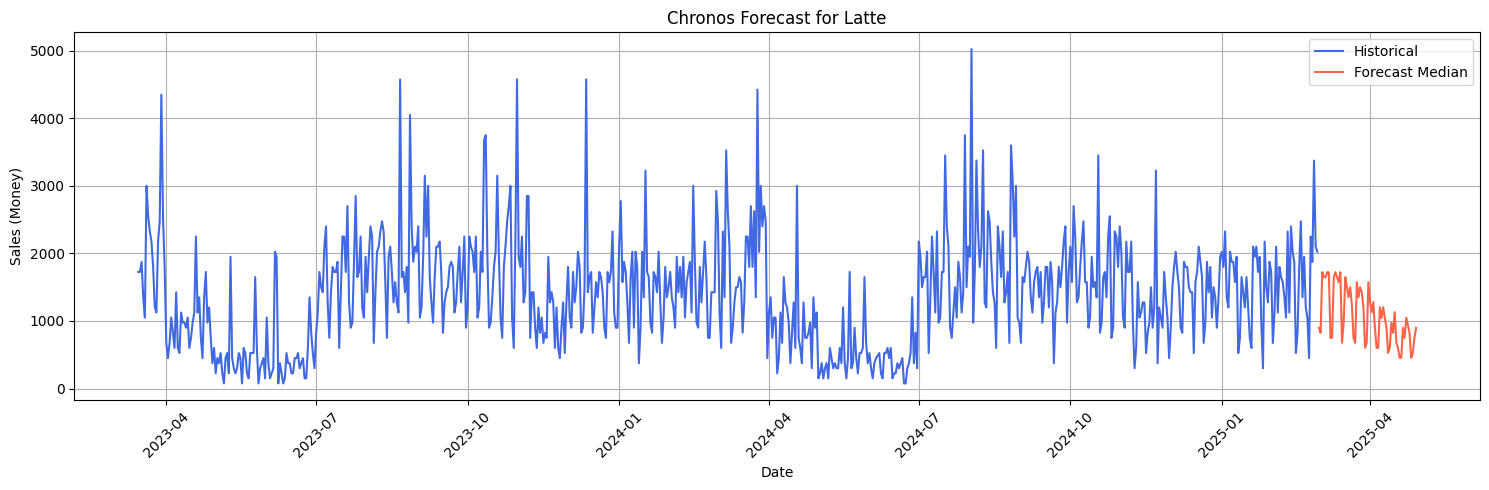

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# กำหนด prediction interval quantiles
lower_q, median_q, upper_q = 0.1, 0.5, 0.9

# Loop ผ่านแต่ละสินค้า
for product, group in forecast_df.groupby('coffee_name'):
    # Historical data ของสินค้านั้น
    historical = daily_sales_features_per_product[
        (daily_sales_features_per_product['coffee_name'] == product) &
        (daily_sales_features_per_product['date'] < split_date)
    ].copy()

    # Forecast ของสินค้านั้น
    forecast_vals = group['forecast_median'].values
    forecast_dates = group['date']

    plt.figure(figsize=(15, 5))

    # Plot historical
    plt.plot(historical['date'], historical['money'], color='royalblue', label='Historical')

    # Plot forecast median
    plt.plot(forecast_dates, forecast_vals, color='tomato', label='Forecast Median')

    plt.title(f'Chronos Forecast for {product}')
    plt.xlabel('Date')
    plt.ylabel('Sales (Money)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [36]:
forecast[0][:][0]

tensor([ 454.1252,  454.1252, 1953.7944, 1499.6692, 2027.7217, 2481.8469,
        1425.7419,  380.1978,  897.6893, 1277.8871, 1795.3787, 1573.5967,
        1721.4514, 1721.4514,  675.9073, 1045.5441, 1277.8871, 1499.6692,
        1721.4514, 1203.9598, 1573.5967,  897.6893, 1351.8146, 2851.4839,
        1045.5441, 1499.6692, 1573.5967, 1013.8608,  454.1252, 1277.8871,
        1689.7681, 1130.0325, 2851.4839, 1573.5967, 1013.8608,  749.8347,
         823.7620, 1203.9598, 1235.6429, 2851.4839, 1351.8146, 1647.5239,
         601.9799,  675.9073, 1277.8871,  823.7620, 1351.8146, 1130.0325,
         675.9073,  454.1252,  601.9799, 1647.5239,  675.9073,  897.6893,
        1351.8146,  823.7620, 1203.9598,  675.9073, 1130.0325, 1045.5441])

In [37]:
import numpy as np

prediction_length = 60

# Dictionary เก็บ median forecast ของแต่ละสินค้า
median_forecasts = {}

for product, group in daily_sales_features_per_product.groupby('coffee_name'):
    # ข้อมูลก่อน split date
    historical = group[group['date'] < split_date].copy()
    context = torch.tensor(historical['money'].values)

    # Forecast ด้วย pipeline ของ Chronos
    forecast = pipeline.predict(context, prediction_length)

    # คำนวณ median ของ forecast
    median_forecast = np.median(forecast[0].numpy(), axis=0)

    median_forecasts[product] = median_forecast

# แสดงผล
for product, median_pred in median_forecasts.items():
    print(f"\n=== {product} ===")
    print(f"Median Forecast (next {prediction_length} days):")
    print(median_pred)



=== Americano ===
Median Forecast (next 60 days):
[ 681.9226   648.495    976.08527 1073.0253  1203.3928  1236.8203
  976.08527  521.4702   648.495   1039.5977  1106.4529  1009.5128
  976.08527  862.4315   454.61505  521.4702  1073.0253  1039.5977
 1073.0253  1103.1101   715.35016  488.04263  488.04263  909.2301
 1009.5128   909.2301   942.6577   681.9226   421.18747  488.04263
  748.7777   976.08527 1006.1701   909.2301   812.29016  387.7599
  357.67508  909.2301   748.7777   812.29016  925.94385  588.3254
  371.0461   387.7599   681.9226   812.29016  715.35016  715.35016
  648.495    421.18747  327.59027  715.35016  454.61505  421.18747
  488.04263  357.67508  227.30753  294.1627   357.67508  327.59027]

=== Americano with Milk ===
Median Forecast (next 60 days):
[1122.4169  1015.2771  1749.95    2173.4072  1540.7722  1816.2747
 1433.6326   872.4241   836.71075 1785.6632  1714.2367  1576.4855
 1540.7722  1326.4927  1015.2771   908.1373  1540.7722  1612.1987
 1540.7722  1505.0591  12